Using this to plot distributions of reaction centres of TS structures from initial model (D_init), final model (D,after NLS optimisation), ground truth, and linear approximation.
**Note**: reaction core created by observing adjacency matrix. 
 
**TODO**: 
- All for test geometries currently. Ideally, want to do on train/val too to see how the model develops.
- All for D_init currently. Want to do similar for W and GNN embedding.
- Can optimise the D_init here OR could save D_init and optimised version during training/testing. 


In [1]:
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem

import numpy as np
from scipy import stats
from scipy.optimize import least_squares
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sys.path.insert(0, "Users/rmhavij/ts_gen/create_figs/scripts/")
# from gaussian import Gaussian

In [28]:
# base_folder = r'../data/raw/' # normal
base_folder = 'Users/rmhavij/3d-reactions/data/raw/' # azure

test_ts_file = base_folder + 'test_ts.sdf'
reactant_file = base_folder + 'test_reactants.sdf'
product_file = base_folder + 'test_products.sdf'
model_ts_no_opt_file = base_folder + 'model_ts.sdf'

test_r = Chem.SDMolSupplier(reactant_file, removeHs=False, sanitize=False)
test_r = [x for x in test_r]

test_ts = Chem.SDMolSupplier(test_ts_file, removeHs=False, sanitize=False)
test_ts = [ts for ts in test_ts]

test_p = Chem.SDMolSupplier(product_file, removeHs=False, sanitize=False)
test_p = [x for x  in test_p]

# will need to add my non-optimised versions later
model_ts_no_opt = Chem.SDMolSupplier('Users/rmhavij/3d-reactions/notebooks/data/model_ts.sdf', removeHs=False, sanitize=False)
model_ts_no_opt = [x for x  in model_ts_no_opt]

In [29]:
D_init = np.load('Users/rmhavij/3d-reactions/notebooks/data/D_init.npy')
created_d_init = np.load('Users/rmhavij/3d-reactions/notebooks/data/new_D_init.npy')
# created_d_init = np.load('Users/rmhavij/ts_gen/azure-experiments/log/21May28_0634AM/D_init.npy')

In [30]:
# check triangle inequalities for model structures before optimisation
from itertools import permutations

for mol in model_ts_no_opt:
    d = Chem.Get3DDistanceMatrix(mol)
    for p in permutations(range(6), 3):
        assert(d[p[0], p[1]] + d[p[0], p[2]] >= d[p[1], p[2]])

In [31]:
# all for reaction core

ground_truth = []  
linear_approx = []
mit_d_init = []
mit_d_final = []
my_d_init = [] # feed my created D_init into this (e.g. from modifying their model, my own model, etc.)

num_test_mols = len(test_ts)

# 842 total, first 840 spawn so hacky solution for now
for idx in range(num_test_mols - 2):
    
    # get N and create mask for reaction core based off adjacency matrices
    N = test_ts[idx].GetNumAtoms()
    core_mask = (Chem.GetAdjacencyMatrix(test_p[idx]) + Chem.GetAdjacencyMatrix(test_r[idx])) == 1 # i.e. any connections that have changed are considered the "core"; otherwise = 0 or 1
    
    # need to modify model_ts_no_opt 
    ground_truth.append(np.ravel(Chem.Get3DDistanceMatrix(test_ts[idx]) * core_mask))
    linear_approx.append(np.ravel( (Chem.Get3DDistanceMatrix(test_r[idx]) + Chem.Get3DDistanceMatrix(test_p[idx])) / 2 * core_mask))
    mit_d_init.append(np.ravel(D_init[idx][0:N,0:N] * core_mask))
    my_d_init.append(np.ravel(created_d_init[idx][0:N,0:N] * core_mask)) 

    # last two don't spawn because can't be optimised
    try:
        mit_d_final.append(np.ravel(Chem.Get3DDistanceMatrix(model_ts_no_opt[idx]) * core_mask))
    except:
        print(idx) 

# concat + ravel
ground_truth_all = np.concatenate(ground_truth).ravel()
linear_approx_all = np.concatenate(linear_approx).ravel()
mit_d_init_all = np.concatenate(mit_d_init).ravel()
mit_d_final_all = np.concatenate(mit_d_final).ravel() 
my_d_init_all = np.concatenate(my_d_init).ravel()

# remove all atoms that haven't moved TODO: why didn't adjacency matrix capture these?
ground_truth_all = ground_truth_all[ground_truth_all != 0]
linear_approx_all = linear_approx_all[linear_approx_all != 0]
mit_d_init_all = mit_d_init_all[mit_d_init_all != 0]
mit_d_final_all = mit_d_final_all[mit_d_final_all != 0] 
my_d_init_all = my_d_init_all[my_d_init_all != 0]

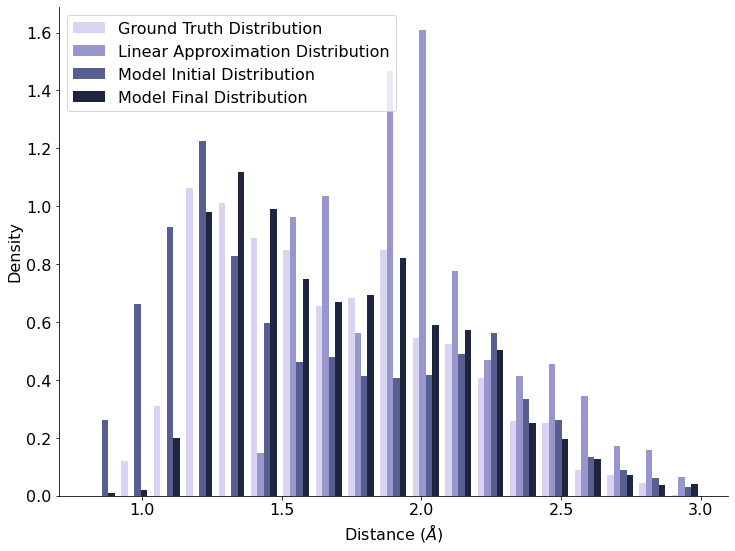

In [34]:
fig, ax = plt.subplots(figsize=(12,9))

bins = np.linspace(0.8, 3, 20)
ax.hist([ground_truth_all, linear_approx_all, mit_d_init_all, mit_d_final_all], bins, range=(0.8, 3), density=True,\
        label=['Ground Truth Distribution', 'Linear Approximation Distribution', 'Model Initial Distribution', 'Model Final Distribution'],\
       color=sns.cubehelix_palette(4, start=2.8, rot=.1))
ax.legend(loc='upper right')

ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)   

# figs_folder = 'Users/rmhavij/3d-reactions/notebooks/figs/'
# plt.savefig(figs_folder + 'distance_distributions.png', bbox_inches='tight')

/anaconda/envs/tsir-rdkit-env-plotting/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/tsir-rdkit-env-plotting/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


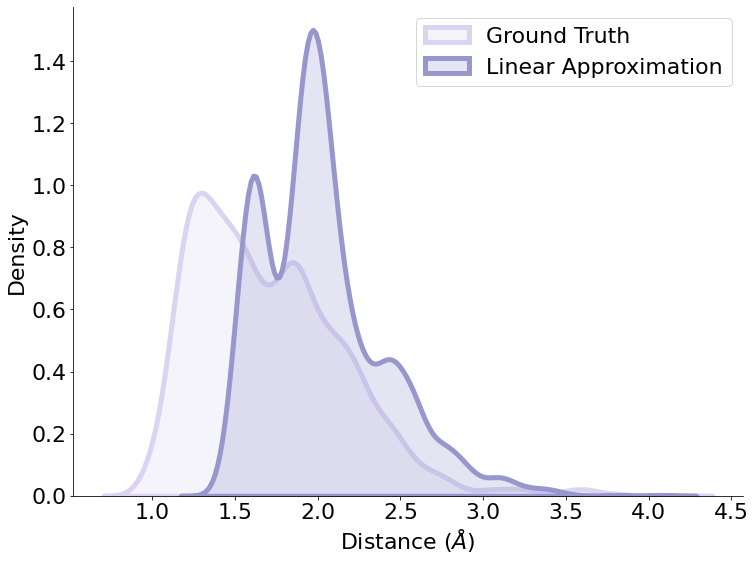

In [37]:
fig, ax = plt.subplots(figsize=(12,9))

num_distr = 4
# may need clearer colours here!
cols = sns.cubehelix_palette(num_distr, start=2.8, rot=.1)

sns.distplot(ground_truth_all, color=cols[0], kde_kws={"ls": '-', "shade": True,"lw": 5, "label": "Ground Truth"}, hist=False)
sns.distplot(linear_approx_all, color=cols[1], kde_kws={"ls": '-', "shade": True,"lw": 5, "label": "Linear Approximation"}, hist=False)
#sns.distplot(mit_d_init_all, color=cols[2], kde_kws={"ls": '-', "shade": True, "lw": 5, "label": "Initial Model ($D_{init}$)"}, hist=False)
#sns.distplot(mit_d_final_all, color=cols[3], kde_kws={"ls": '-', "shade": True,"lw": 5, "label": "Final $D_{init}$"}, hist=False)

# sns.palplot(sns.cubehelix_palette(20, start=2.8, rot=.1))

ax.legend(loc='best')

ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.legend(fontsize=22)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 

figs_folder = 'Users/rmhavij/3d-reactions/notebooks/figs/'
# plt.savefig(figs_folder + 'distance_distributions_nice.png', bbox_inches='tight')

Doing the same but on the training set to identify deviation from R and P.

In [2]:
# base_folder = r'../data/raw/' # normal
base_folder = 'Users/rmhavij/3d-reactions/data/raw/' # azure

train_reactant_file = base_folder + 'train_reactants.sdf'
train_ts_file = base_folder + 'train_ts.sdf'
train_product_file = base_folder + 'train_products.sdf'

train_r = Chem.SDMolSupplier(train_reactant_file, removeHs=False, sanitize=False)
train_r = [x for x in train_r]

train_ts = Chem.SDMolSupplier(train_ts_file, removeHs=False, sanitize=False)
train_ts = [ts for ts in train_ts]

train_p = Chem.SDMolSupplier(train_product_file, removeHs=False, sanitize=False)
train_p = [x for x  in train_p]

In [50]:
# all for reaction core

train_gt = [] # ground truth
train_la = [] # linear approximation

num_train_mols = len(train_r)

for idx in range(num_train_mols):

    # get N and create mask for reaction core based off adjacency matrices
    N = train_ts[idx].GetNumAtoms()
    core_mask = (Chem.GetAdjacencyMatrix(train_r[idx]) + Chem.GetAdjacencyMatrix(train_p[idx])) == 1   

    train_gt.append(np.ravel(Chem.Get3DDistanceMatrix(train_ts[idx]) * core_mask))
    train_la.append(np.ravel(((Chem.Get3DDistanceMatrix(train_r[idx]) + Chem.Get3DDistanceMatrix(train_p[idx]))/2) * core_mask))
    
    # TODO: create and add in training D_init here

# concat + ravel
train_gt_all = np.concatenate(train_gt).ravel()
train_la_all = np.concatenate(train_la).ravel()

# remove all atoms that haven't moved
train_gt_all = train_gt_all[train_gt_all != 0]
train_la_all = train_la_all[train_la_all != 0]

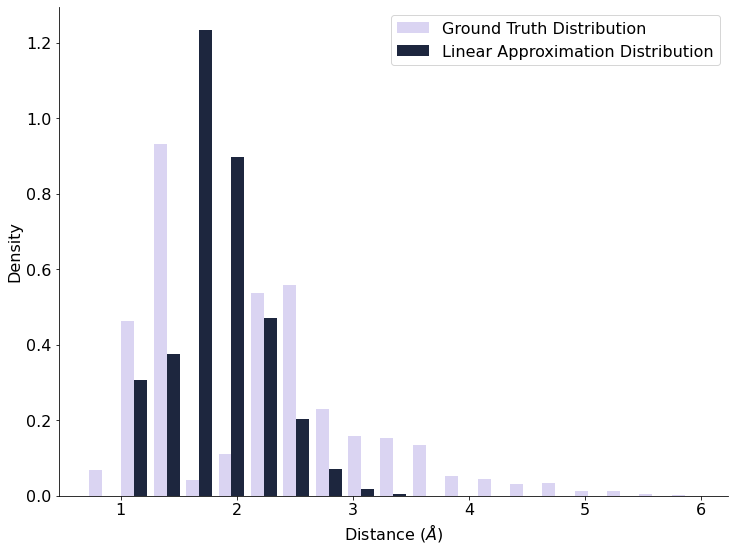

In [51]:
fig, ax = plt.subplots(figsize=(12,9))

# note: if you do linspace(0, ...) then you get lots of zeroes where they are the same
bins = np.linspace(0.7, 6, 20)
ax.hist([train_gt_all, train_la_all], bins, density=True,\
        label=['Ground Truth Distribution', 'Linear Approximation Distribution'],\
       color=sns.cubehelix_palette(2, start=2.8, rot=.1))
ax.legend(loc='upper right')

ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)   

# figs_folder = 'Users/rmhavij/3d-reactions/notebooks/figs/'
# plt.savefig(figs_folder + 'distance_distributions.png', bbox_inches='tight')

/anaconda/envs/tsir-rdkit-env-plotting/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/tsir-rdkit-env-plotting/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


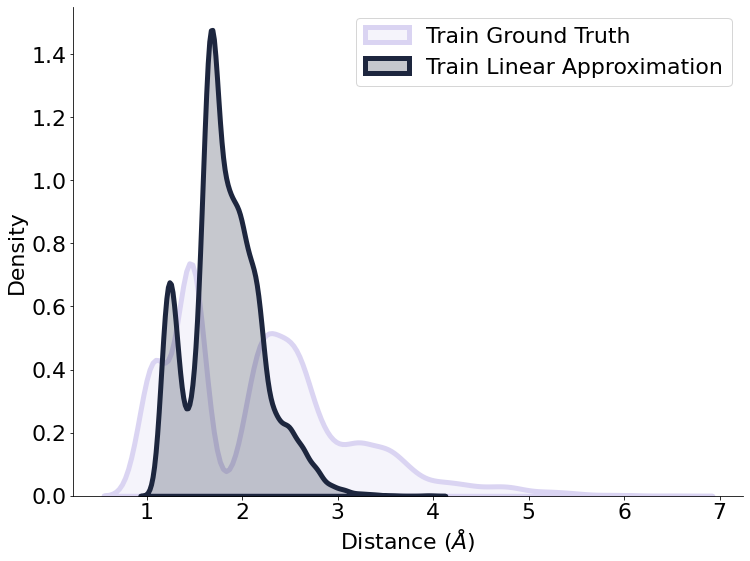

In [52]:
fig, ax = plt.subplots(figsize=(12,9))

num_distr = 2
# may need clearer colours here!
cols = sns.cubehelix_palette(num_distr, start=2.8, rot=.1)

#sns.distplot(train_gt_all, color=cols[0], kde_kws={"ls": '-', "shade": True,"lw": 5, "label": "Train Ground Truth"})
#sns.distplot(train_la_all, color=cols[1], kde_kws={"ls": '-', "shade": True,"lw": 5, "label": "Train Linear Approximation"})

sns.distplot(train_gt_all, color=cols[0], kde_kws={"ls": '-', "shade": True,"lw": 5, "label": "Train Ground Truth"}, hist=False)
sns.distplot(train_la_all, color=cols[1], kde_kws={"ls": '-', "shade": True,"lw": 5, "label": "Train Linear Approximation"}, hist=False)

ax.legend(loc='best')

ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.legend(fontsize=22)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 

figs_folder = 'Users/rmhavij/3d-reactions/notebooks/figs/'
# plt.savefig(figs_folder + 'distance_distributions_nice.png', bbox_inches='tight')